# Project 1

In [1]:
%matplotlib inline
import numpy as np
import numpy.linalg as la
from scipy.misc import imread
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
flights = np.genfromtxt('flights.csv', skip_header=1, delimiter=',')
T, X_orig = flights.T  # unpack the columns

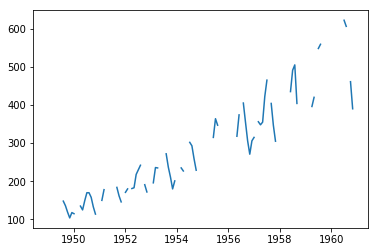

In [3]:
plt.plot(T, X_orig);

### Explanation

We use Alternating Least Squares method to solve our problem according to AR model. For the missing data in our time series, we use linear interpolation as an initial estimate.

In [4]:
def linear_interpolation(data, first, last):
    """
    Given a sequence of scalar data points containing NaN values,
    returns a numpy array where previously NaN values are linearly
    interpolated values between the closest left and right non-NaN
    values.
    
    data : Sequence of data points.
    leftmost : Leftmost value of the data sequence.
    rightmost : Rightmost value of the data sequence.
    """
    X = np.array(data).copy()
    on_nan = False
    begin = 0
    end = len(X)
    for i in range(len(X)):
        if not on_nan and np.isnan(X[i]):
            on_nan = True
            begin = i - 1
        if on_nan and not np.isnan(X[i]):
            end = i
            on_nan = False
            count = end - begin - 1
            b_val = X[begin] if begin >= 0 else first
            e_val = X[end] if end < len(X) - 1 else last
            X[begin + 1:end] = np.linspace(b_val, e_val, num=count)
    if np.isnan(X[-1]):
        X[-1] = last
    return X

### Constants Throughout the Iteration

In [5]:
# size constants
M = 4
N = len(X_orig) - 1
# Indices for X when setting G_X at each step
x_indices = np.column_stack(range(M - i, N - i + 1) for i in range(1, M + 1))
# G_A skeleton
G_A = np.zeros((N - M + 1, N + 1))
row_indices = np.arange(0, N - M + 1)
col_indices = np.arange(M, N + 1)
G_A[row_indices, col_indices] = -1
# Indices for G_A when setting G_A at each step
row_indices = np.column_stack(range(N - M + 1) for _ in range(M))
col_indices = x_indices[:, ::-1]
a_indices = (row_indices, col_indices)
# data constants
missing_vals = np.isnan(X_orig)
X_ob = X_orig[~missing_vals]

### Iteration

In [60]:
# initialize NaN values
X = linear_interpolation(
    X_orig,
    first=np.min(X_ob),
    last=np.max(X_ob),
)
for _ in range(50):
    # find A via least squares (R*x = Q.T*b)
    G_X = X[x_indices]
    b = X[M:]
    Q, R = la.qr(G_X)
    A = la.solve(R, np.dot(Q.T, b))
    # find X via least squares
    G_A[a_indices] = A
    G_A_ob = G_A[:, ~missing_vals]
    G_A_mi = G_A[:, missing_vals]
    Q, R = la.qr(G_A_mi)
    b = np.dot(-G_A_ob, X_ob)
    X_mi = la.solve(R, np.dot(Q.T, b))
    X[missing_vals] = X_mi

### Plotting

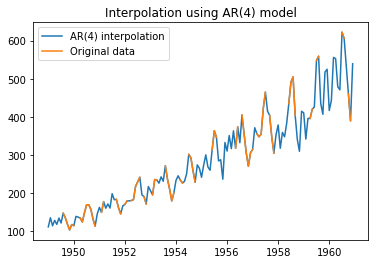

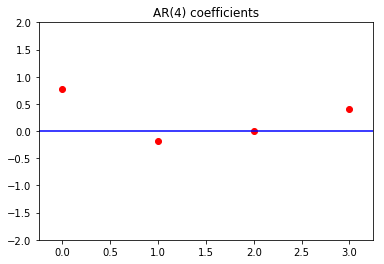

[ 0.78309444 -0.18019109  0.00573093  0.40554038]


In [7]:
plt.plot(T, X, label='AR(4) interpolation')
plt.plot(T, X_orig, label='Original data')
plt.legend()
plt.title('Interpolation using AR(4) model')
plt.show()

plt.plot(A, 'or')
plt.xlim([-0.25, 3.25])
plt.ylim([-2, 2])
plt.axhline(0, color='blue')
plt.title('AR(4) coefficients')
plt.show()
print(A)

# Project 2

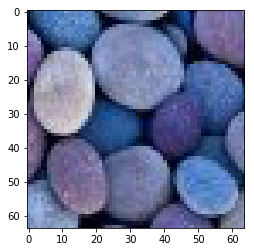

In [8]:
img = imread('stones_rgb.jpg')
plt.imshow(img);

### Constants and Functions

We define $sim(i, j)$ function for the similarity of pixels at $i^{th}$ and $j^{th}$

In [9]:
h = len(img)  # number of rows
n = h*h
r = 2
sigma = 10.0
L = np.array([
    [ 0.299   ,  0.587  ,  0.114  ],
    [-0.14713 , -0.28886,  0.436  ],
    [ 0.615   , -0.51499, -0.10001],
])

def sim(i, j):
    '''
    Return the similarity between two pixels at single indices i and j.
    
    Index i is translated to (x, y) coordinates with the following formula:
    i = x + y*h
    '''
    xi = i%h
    yi = (i - xi)//h
    xj = j%h
    yj = (j - xj)//h
    if i == j or abs(xi - xj) > r or abs(yi - yj) > r:
        return 0
    ci = img[xi, yi]
    cj = img[xj, yj]
    diff = ci - cj
    weighted_norm_sq = np.sum(np.dot(L, diff)**2)
    return np.exp(-weighted_norm_sq/(2*sigma*sigma))

### Construct W

Since $sim(i, j) = sim(j, i)$, we calculate only the upper half of the matrix $W$ and then set the lower triangle equal to the upper triangle such that $W = W^T$.

In [10]:
W = np.zeros((n, n), dtype='float64')
for i in range(n):
    for j in range(i + 1, n):
        W[i, j] = sim(i, j)
# construct a symmetric matrix where upper triangle is non-negative
# and lower triangle is zero.
W = np.maximum(W, W.T)

### Construct L

In [11]:
D = np.sum(W, axis=1)  # don't need the whole matrix explicitly.
D_inv_sqroot = 1/np.sqrt(D)
L = D_inv_sqroot[:, np.newaxis]*W*D_inv_sqroot

### Calculate eigenvectors and matrix $V$

We calculate the eigenvectors corresponding to the largest (in absolute value) $k$ eigenvalues of the matrix $L$ via simultaneous iteration.

In [50]:
k = 5
Q, _ = la.qr(np.random.randn(n, k))
for i in range(500):
    Q, _ = la.qr(np.dot(L, Q))
    
V = D_inv_sqroot[:, np.newaxis]*Q

### Plotting

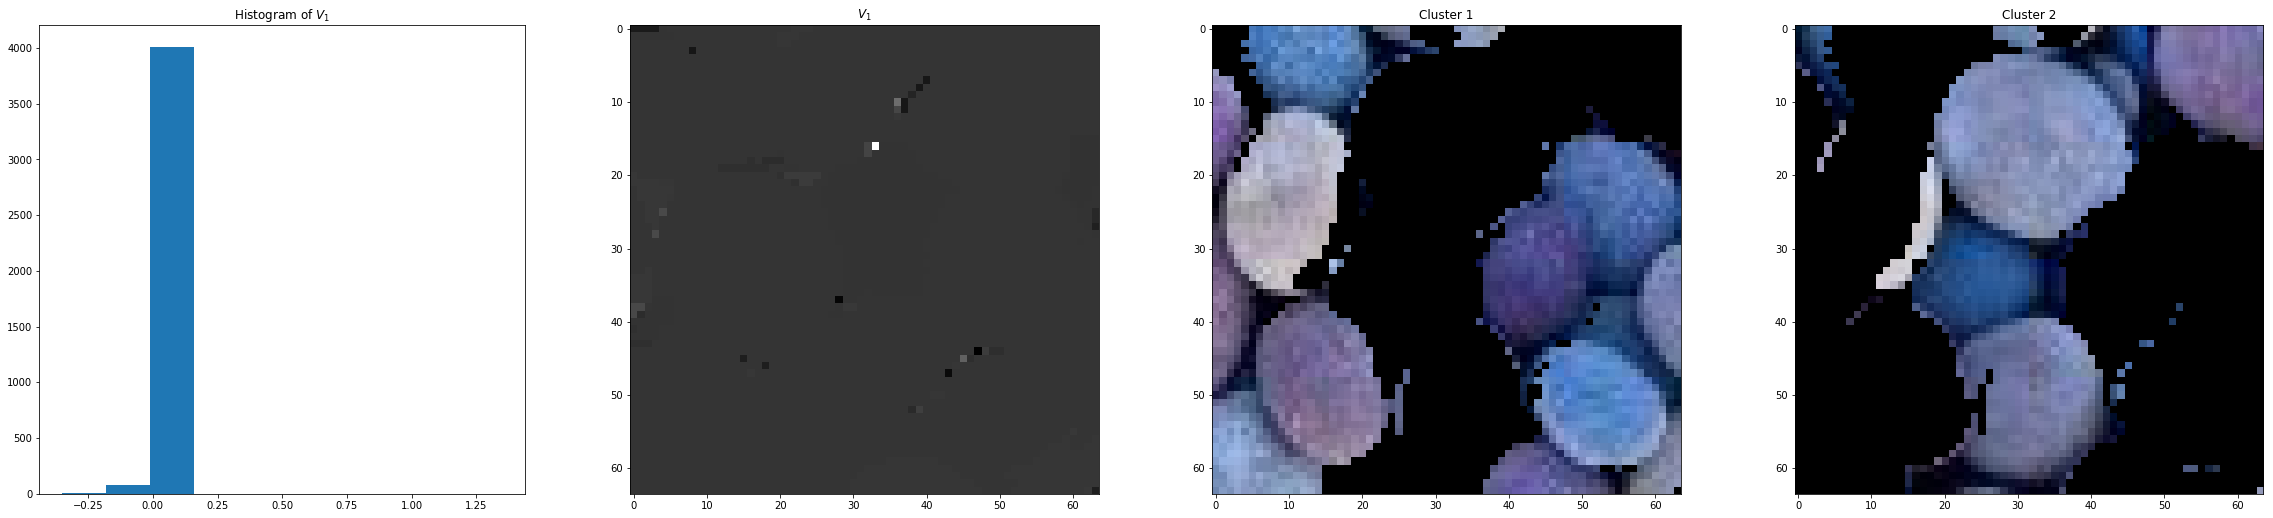

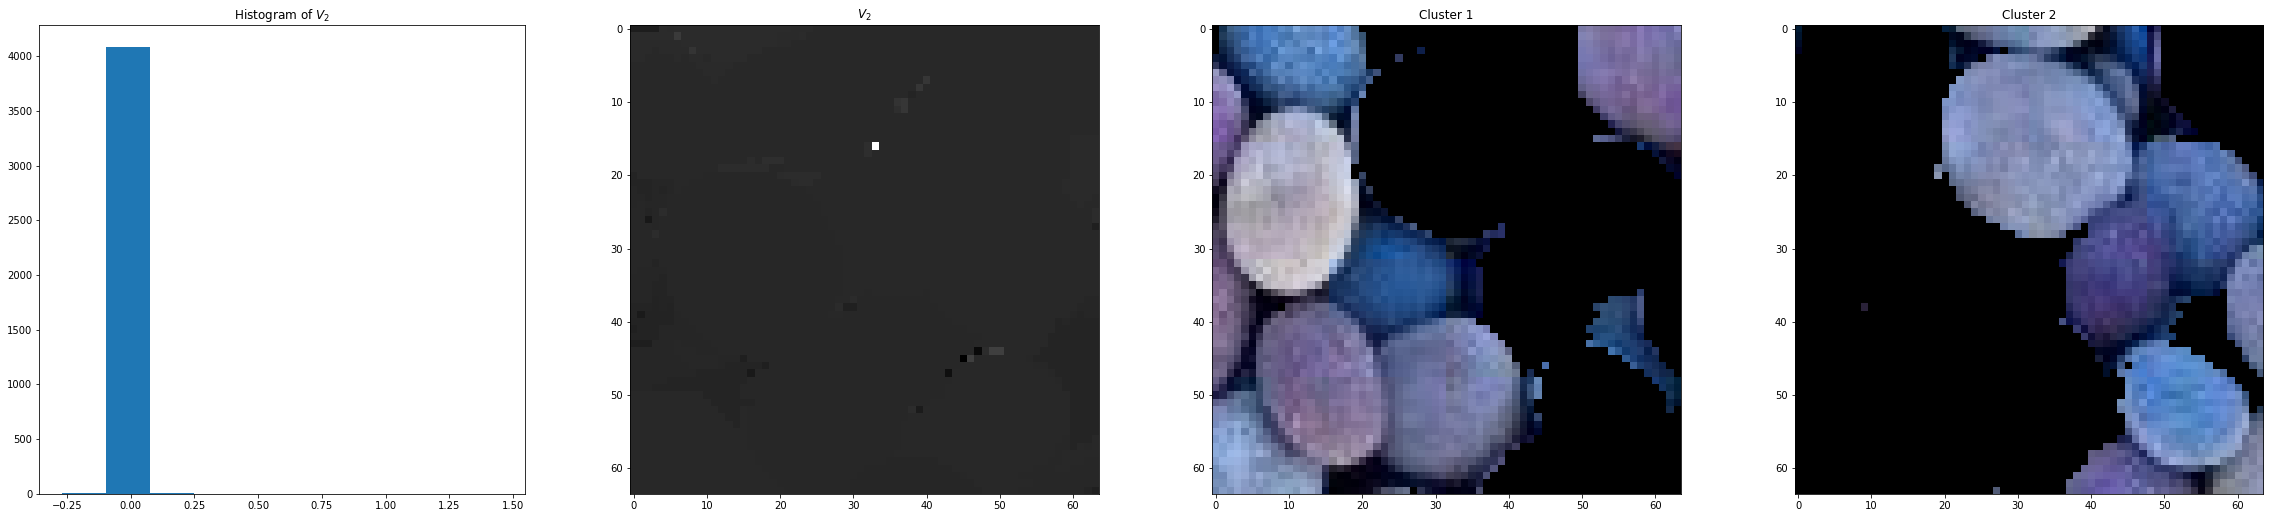

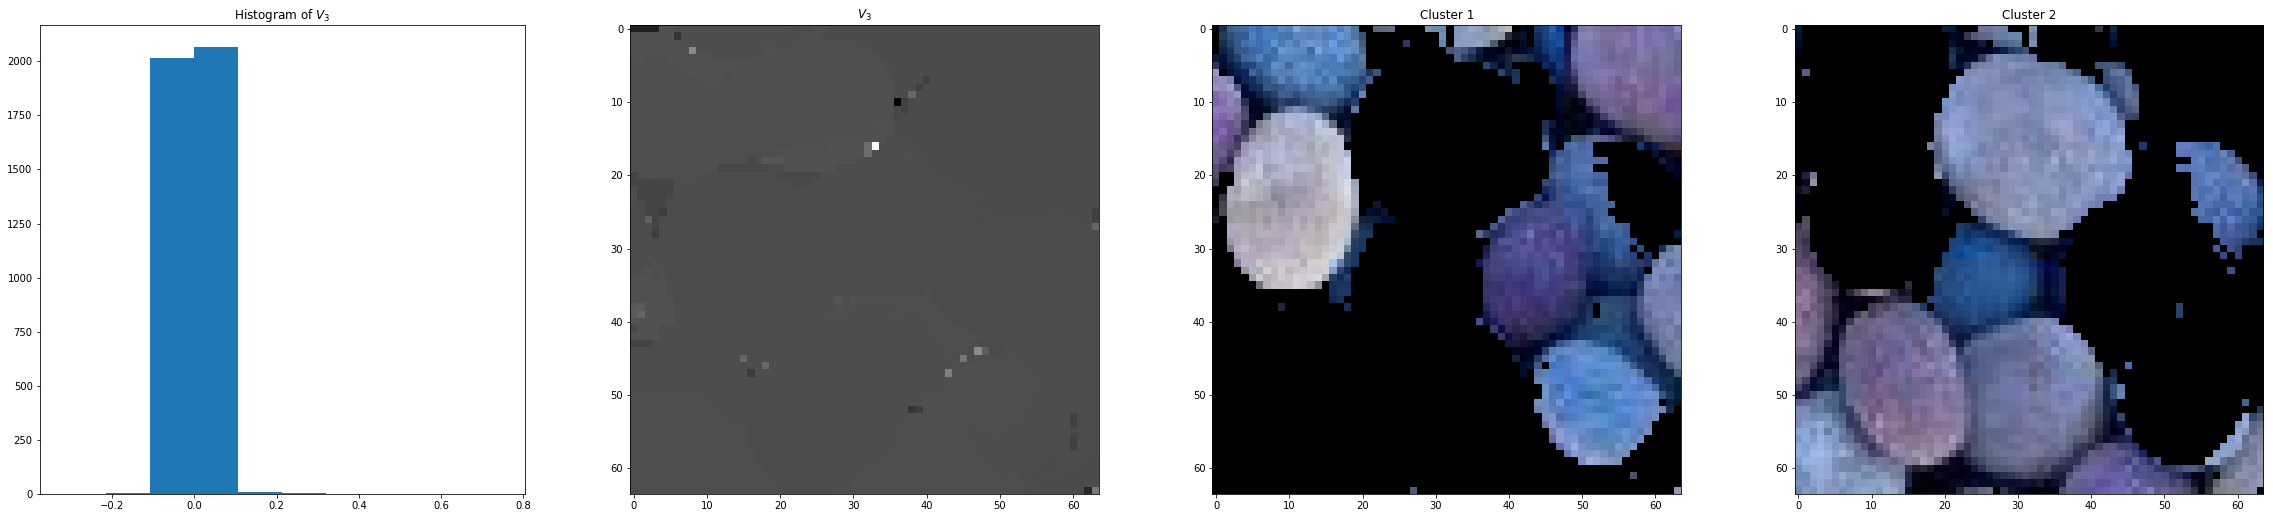

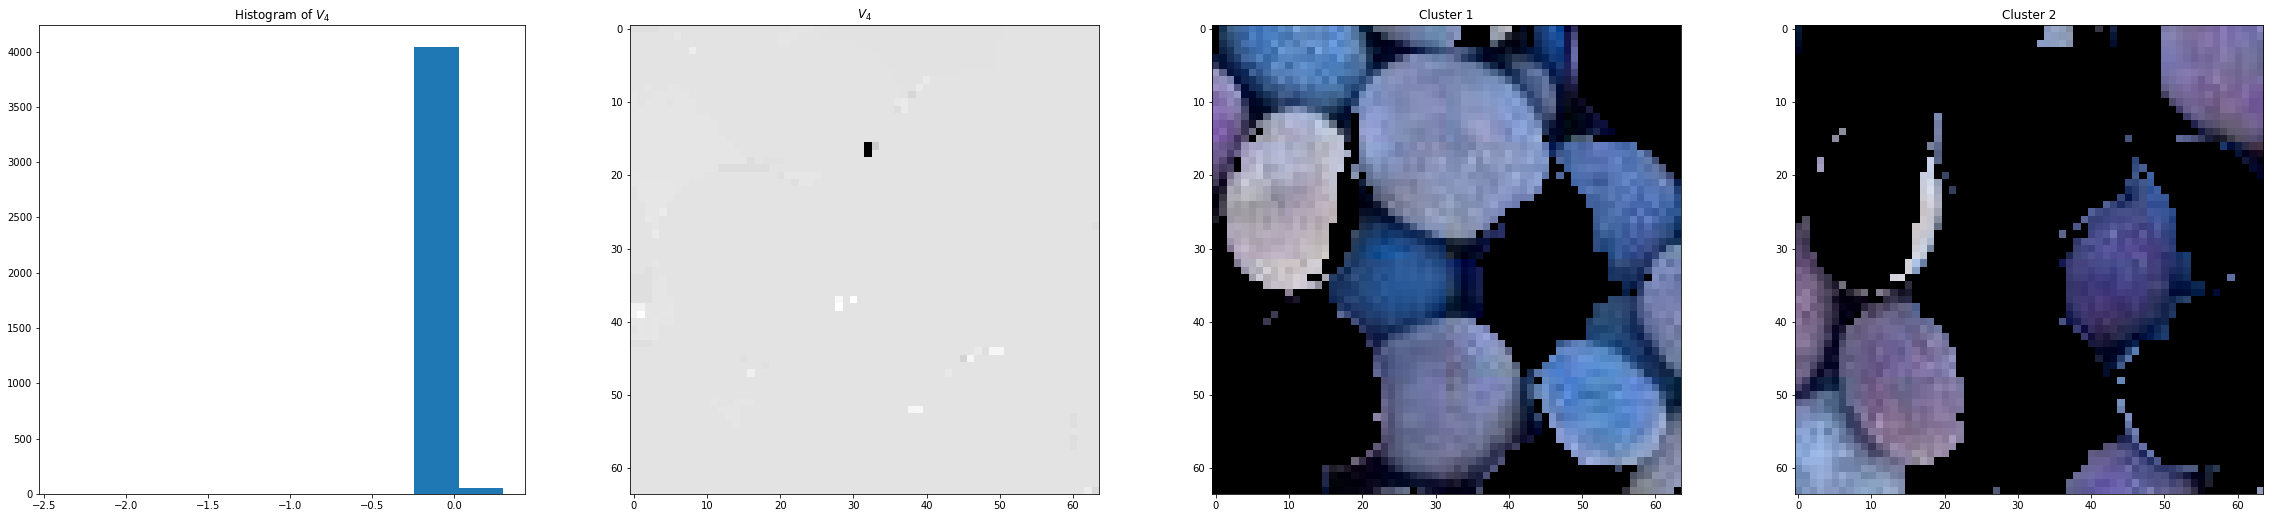

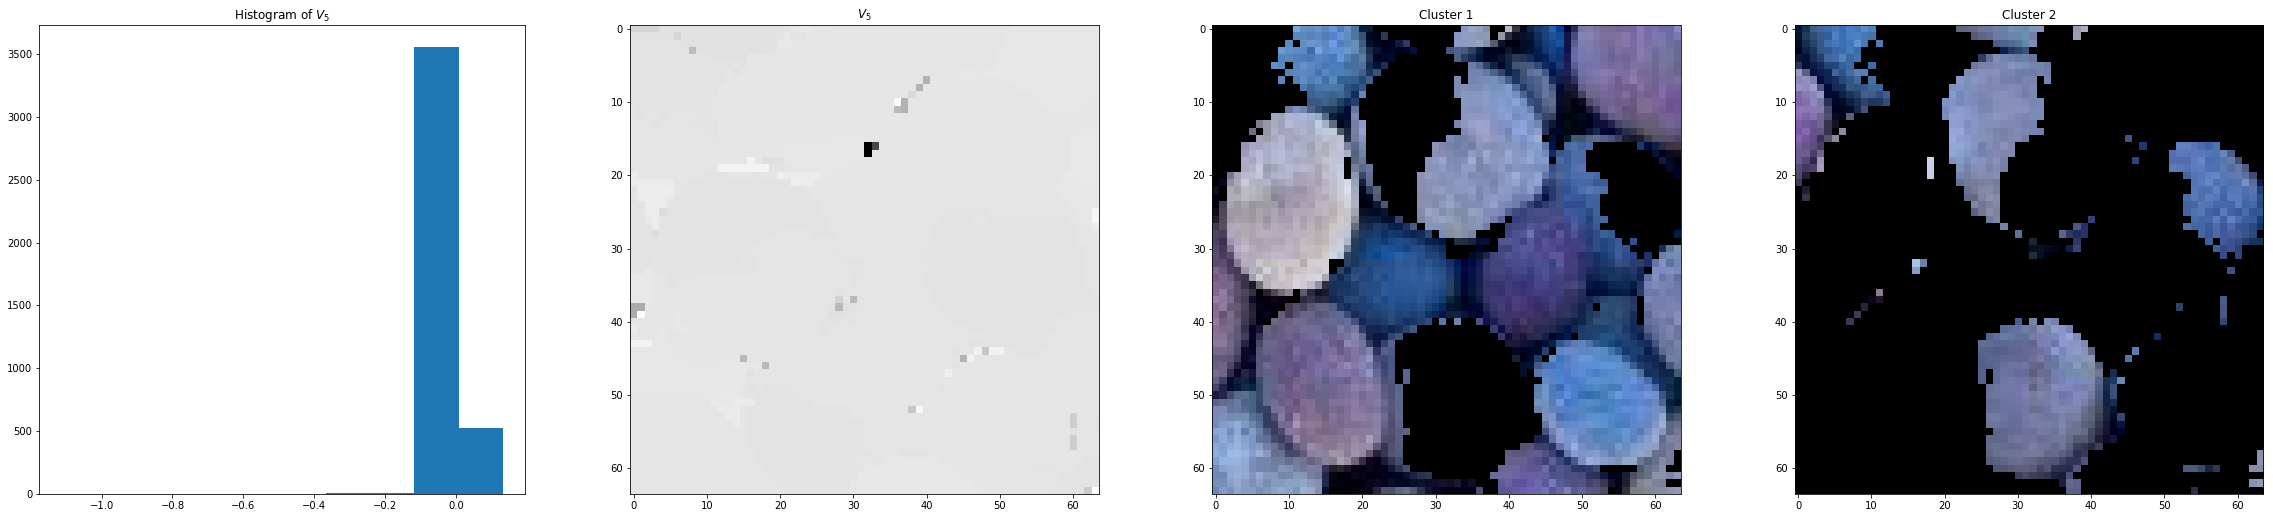

In [51]:
cols = 4
for i in range(k):
    plt.figure(figsize=(40, 50))  # adjust the image size to your preference.
    v = V[:, i]
    
    plt.subplot(k, cols, i*cols + 1)
    plt.hist(v)
    plt.title(r'Histogram of $V_{}$'.format(i + 1))
    
    plt.subplot(k, cols, i*cols + 2)
    plt.imshow(v.reshape(h, h), cmap='gray')
    plt.title(r'$V_{}$'.format(i + 1))
    
    cluster1 = img.copy()
    cluster2 = img.copy()
    for x in range(h):
        for y in range(h):
            if v[x + y*h] < 0:
                cluster1[x, y] = 0
            else:
                cluster2[x, y] = 0
                
    plt.subplot(k, cols, i*cols + 3)
    plt.imshow(cluster1)
    plt.title('Cluster 1')
    plt.subplot(k, cols, i*cols + 4)
    plt.imshow(cluster2)
    plt.title('Cluster 2')
    
    plt.show()

### Image Segmentation via k-means Clustering

In [53]:
norms = la.norm(V, axis=1)
V_normalized = V/norms[:, np.newaxis]
kmeans = KMeans(n_clusters=20)
labels = kmeans.fit_predict(V_normalized)

In [54]:
segments = np.empty((h, h), dtype='float')
for x in range(h):
    for y in range(h):
        segments[x, y] = labels[x + y*h]

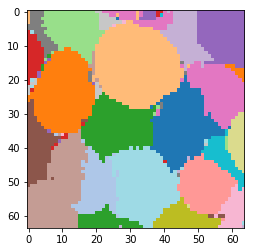

In [59]:
plt.imshow(segments, cmap='Vega20');